# Homework 3 - Coloring
### Problem a

In this example, study a line graph with 10 nodes. Denote the \( i \)-th node state by \( X_i(t) \) and the set of possible states by \( C = \{\text{red, green}\} \). At initialization, each node is red, i.e., \( X_i(t) = \text{red} \) for all \( i = 1, \dots, 10 \). Every discrete time instance \( t \), one node \( I(t) \), chosen uniformly at random, wakes up and updates its color.

The new color (resulting from a node's update) is chosen from a probability distribution given by

$$
P(X_i(t+1) = a \mid X(t), I(t) = i) = \frac{e^{-\eta(t) \sum_j W_{ij} c(a, X_j(t))}}{\sum_{s \in C} e^{-\eta(t) \sum_j W_{ij} c(s, X_j(t))}},
$$

where the cost is given by

$$
c(s, X_j(t)) =
\begin{cases} 
1 & \text{if } X_j(t) = s, \\
0 & \text{otherwise.}
\end{cases}
$$

In the above expression, \( \eta(t) \) is the inverse of the noise. To decide upon a good choice of \( \eta(t) \), some heuristics are required, but it is preferable to have it increasing in time so that the noise is decreasing. For this exercise, you can start with

$$
\eta(t) = \frac{t}{50}.
$$

To study how close to a solution the learning algorithm is, we consider the potential function, which is given by

$$
U(t) = \frac{1}{2} \sum_{i, j \in \mathcal{V}} W_{ij} c(X_i(t), X_j(t)),
$$

where \( \mathcal{V} \) is the set of nodes. If the potential is zero, there are no conflicting nodes, and a solution is found.

Your task is to simulate the learning dynamics described above. Include plots of the potential function in your report and briefly comment on the results.


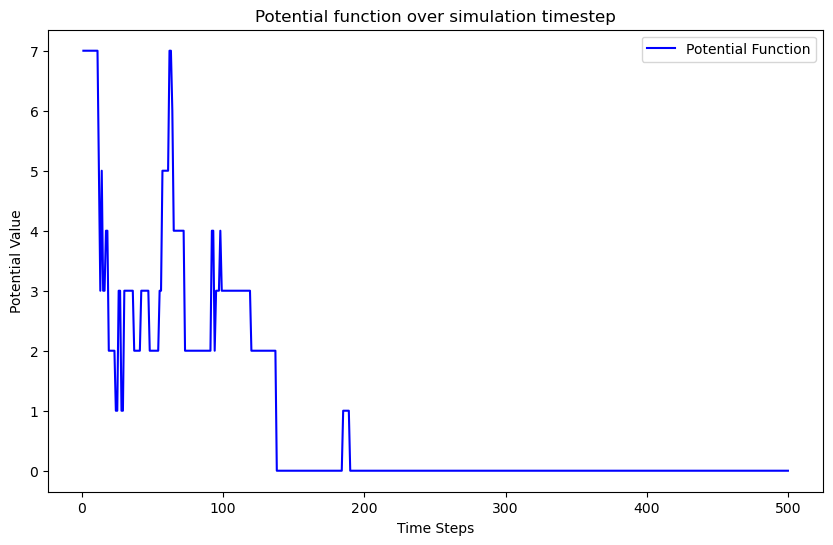

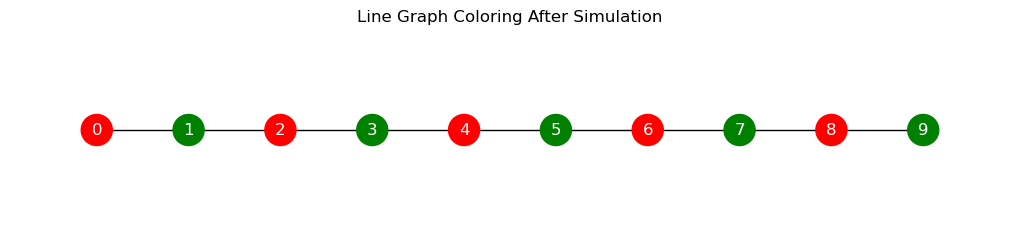

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

num_nodes = 10
colors = ["red", "green"]  # Possible states
eta = lambda t: t / 50  # Noise 
num_iterations = 500 

adjacency_matrix = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    if i > 0:
        adjacency_matrix[i, i - 1] = 1
        adjacency_matrix[i - 1, i] = 1

#visualization
G = nx.Graph()
G.add_edges_from([(i, i + 1) for i in range(num_nodes - 1)])

# all red initially
states = np.array([0] * num_nodes)  # 0 for red, 1 for green

# Cost function
def cost(s, neighbor_state):
    return 1 if s == neighbor_state else 0

# Potential function
def compute_potential(states, adjacency_matrix):
    potential = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i, j] == 1:
                potential += cost(states[i], states[j])
    return potential / 2

# Probability calculation
def calculate_probabilities(node_to_update, states, adjacency_matrix, t):
    probabilities = []
    for color in range(len(colors)):
        total_cost = sum(
            adjacency_matrix[node_to_update, j] * cost(color, states[j])
            for j in range(num_nodes)
        )
        probabilities.append(np.exp(-eta(t) * total_cost))
    probabilities = np.array(probabilities) / sum(probabilities)
    return probabilities

# Simulation
potential_values = []
for t in range(1, num_iterations + 1):
    # Choose a random node to update
    node_to_update = np.random.randint(0, num_nodes)

    # Calculate probabilities for each color
    probabilities = calculate_probabilities(node_to_update, states, adjacency_matrix, t)

    # Update the state based on probabilities
    states[node_to_update] = np.random.choice(len(colors), p=probabilities)

    # Compute and store the potential
    potential = compute_potential(states, adjacency_matrix)
    potential_values.append(potential)


time_steps = list(range(1, num_iterations + 1))
plt.figure(figsize=(10, 6))
plt.plot(time_steps, potential_values, label="Potential Function", color="blue")
plt.xlabel("Time Steps")
plt.ylabel("Potential Value")
plt.title("Potential function over simulation timestep")
plt.legend()
plt.show()

# Plot the graph with final coloring (line graph layout)
final_colors = [colors[state] for state in states]
pos = {i: (i, 0) for i in range(num_nodes)}  # Line graph layout
plt.figure(figsize=(10, 2))
nx.draw(G, pos, with_labels=True, node_color=final_colors, node_size=500, font_color="white")
plt.title("Line Graph Coloring After Simulation")
plt.show()


### Problem b

Next, we use the coloring algorithm for the problem of assigning WiFi channels to routers. The adjacency matrix of a network of 100 routers is given in `wifi.mat`, and the routers' coordinates are given in `coord.mat`. Here, a link between two nodes means that the two routers are able to interfere with each other. The set of possible states is \( C = \{1 : \text{red}, 2 : \text{green}, 3 : \text{blue}, 4 : \text{yellow}, 5 : \text{magenta}, 6 : \text{cyan}, 7 : \text{white}, 8 : \text{black}\} \), where colors represent frequency bands, and the cost function is

$$
c(s, X_j(t)) =
\begin{cases} 
2 & \text{if } X_j(t) = s, \\
1 & \text{if } |X_j(t) - s| = 1, \\
0 & \text{otherwise.}
\end{cases}
$$

The cost function \( c(s, X_j(t)) \) symbolizes that routers that are close by should not use channels with the same frequency band or a frequency band right next to each other.

Use \( \eta(t) = t / 50 \) and verify that a near-zero potential solution is found after a sufficient number of iterations (you can use an arbitrary initial condition). Include plots of the potential functions for some different tested cases and an illustration of the node coloring corresponding to the smallest potential function (that is, the best obtained solution) in the report. Comment briefly on the obtained results.


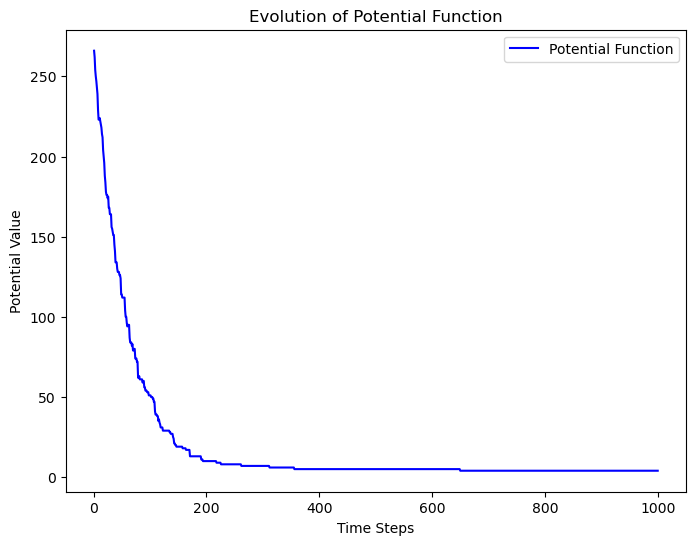

Final Potential (all red initial state): 4.0


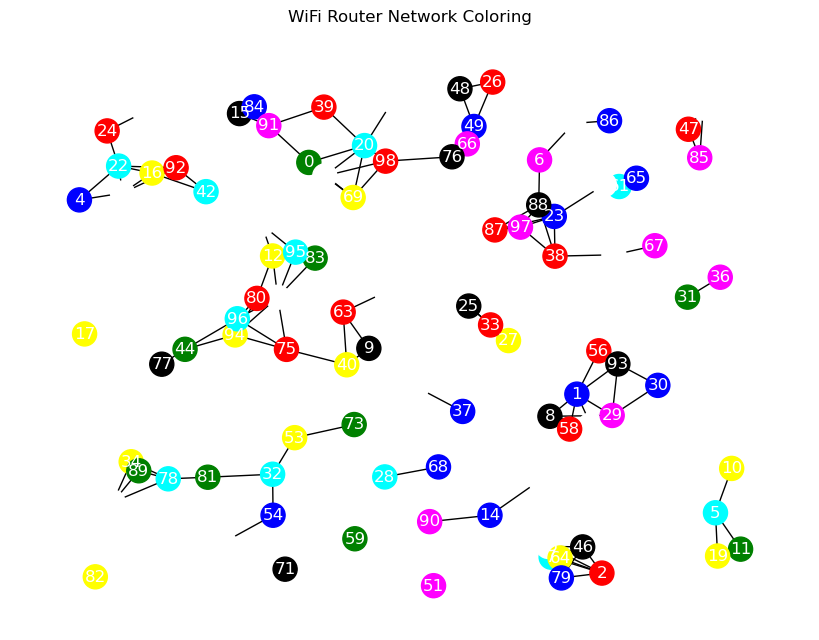

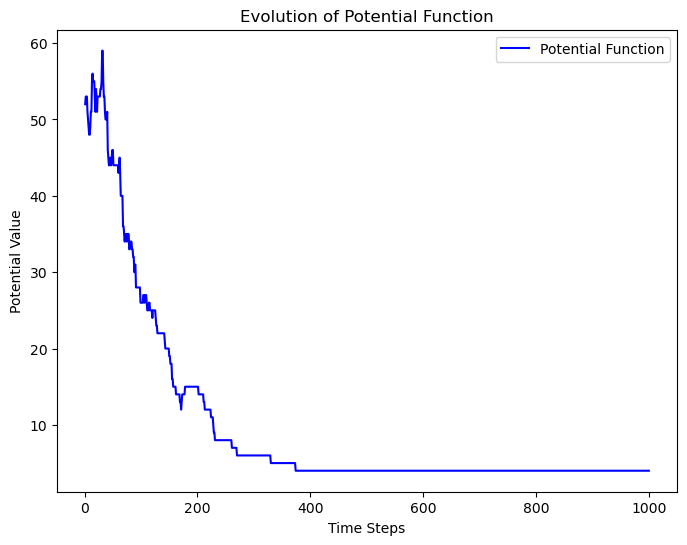

Final Potential (random initial state): 4.0


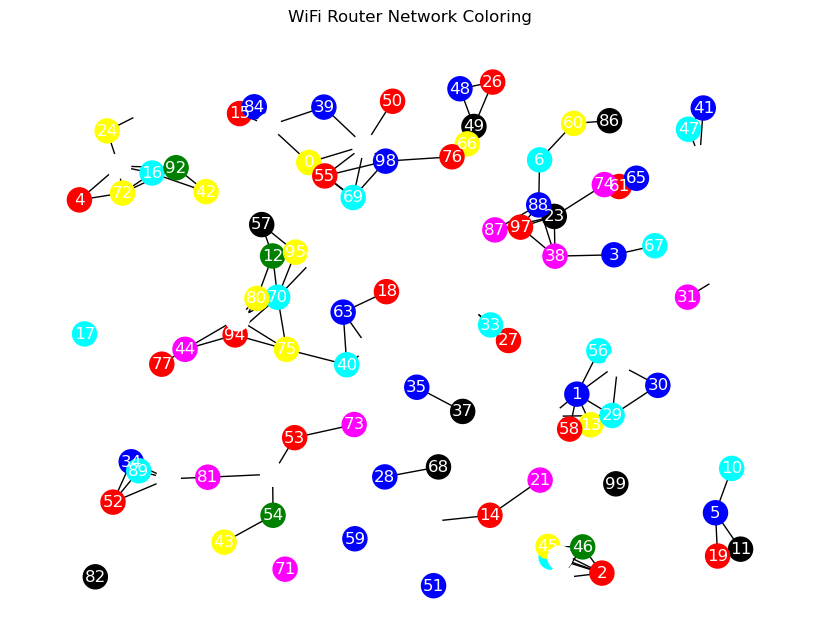

In [13]:
from scipy.io import loadmat

# Load adjacency matrix and coordinates
wifi_data = loadmat('/Users/sepehr/Desktop/wifi.mat')
coords_data = loadmat('/Users/sepehr/Desktop/coords.mat')

adjacency_matrix = wifi_data['wifi']
coordinates = coords_data['coords']

# Create graph from adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# color mapping
colors = {1: 'red', 2: 'green', 3: 'blue', 4: 'yellow', 5: 'magenta', 6: 'cyan', 7: 'black', 8: 'white'}
pos = {node: (coordinates[index][0], coordinates[index][1]) for index, node in enumerate(G)}

# Cost function
def cost_function(color, neighbor_color):
    if neighbor_color == color:
        return 2
    elif abs(neighbor_color - color) == 1:
        return 1
    else:
        return 0

# Potential function
def compute_potential(graph, states):
    potential = 0
    for i in graph.nodes:
        for j in graph.neighbors(i):
            potential += cost_function(states[i], states[j])
    return potential / 2

# Dynamics simulation
def simulate_dynamics(graph, initial_states, colors, max_steps, plot_potential=False):
    states = np.array(initial_states, dtype=int)
    potential_values = []

    for t in range(1, max_steps + 1):
        # Select a random node to update
        node_to_update = np.random.choice(graph.nodes)

        # Calculate probabilities for each color
        probabilities = []
        for color in colors.keys():
            total_cost = sum(cost_function(color, states[neighbor]) for neighbor in graph.neighbors(node_to_update))
            probabilities.append(np.exp(-t / 50 * total_cost))
        probabilities = np.array(probabilities) / sum(probabilities)

        # Update the state of the chosen node
        states[node_to_update] = np.random.choice(list(colors.keys()), p=probabilities)

        # Compute and store the potential
        potential = compute_potential(graph, states)
        potential_values.append(potential)

    # Plot the potential function if required
    if plot_potential:
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, max_steps + 1), potential_values, label="Potential Function", color="blue")
        plt.xlabel("Time Steps")
        plt.ylabel("Potential Value")
        plt.title("Evolution of Potential Function")
        plt.legend()
        plt.show()

    # Return the final states and the final potential
    return states, potential_values[-1]

# Graph plotting
def plot_graph(graph, colors, final_states, pos):
    node_colors = [colors[state] for state in final_states]
    plt.figure(figsize=(8, 6))
    nx.draw(graph, pos=pos, with_labels=True, node_color=node_colors, node_size=300, font_color="white")
    plt.title("WiFi Router Network Coloring")
    plt.show()


max_steps = 1000

# Initial state (all nodes start with color 1 - red)
initial_states = np.ones(G.number_of_nodes(), dtype=int)
final_states, final_potential = simulate_dynamics(G, initial_states, colors, max_steps, plot_potential=True)
print(f"Final Potential (all red initial state): {final_potential}")
plot_graph(G, colors, final_states, pos)

# Try with a different random initial state
initial_states = np.random.choice(list(colors.keys()), size=G.number_of_nodes())
final_states, final_potential = simulate_dynamics(G, initial_states, colors, max_steps, plot_potential=True)
print(f"Final Potential (random initial state): {final_potential}")
plot_graph(G, colors, final_states, pos)
